http://blog.yhat.com/posts/stock-data-python.html
http://blog.yhat.com/posts/stock-data-python-pt2.html

In [24]:
import pandas as pd
# import pandas.io.data as web   # Package and modules for importing data; this code may change depending on pandas version
import datetime
from pandas_datareader import data, wb
import numpy as np


# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()


In [7]:
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
apple = data.DataReader("AAPL", "yahoo", start, end)

type(apple)

apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,107.010002,107.029999,104.820000,105.260002,101.703697,40635300
2016-01-04,102.610001,105.370003,102.000000,105.349998,101.790649,67649400
2016-01-05,105.750000,105.849998,102.410004,102.709999,99.239845,55791000
2016-01-06,100.559998,102.370003,99.870003,100.699997,97.297760,68457400
2016-01-07,98.680000,100.129997,96.430000,96.449997,93.191338,81094400


In [8]:
# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import pylab
# This line is necessary for the plot to appear in a Jupyter notebook (you don't need it if you're working in Rodeo)
%matplotlib inline
# Control the default size of figures in this Jupyter notebook (n/a if working in Rodeo)
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

Populating the interactive namespace from numpy and matplotlib


C:\Users\manasvee\Miniconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


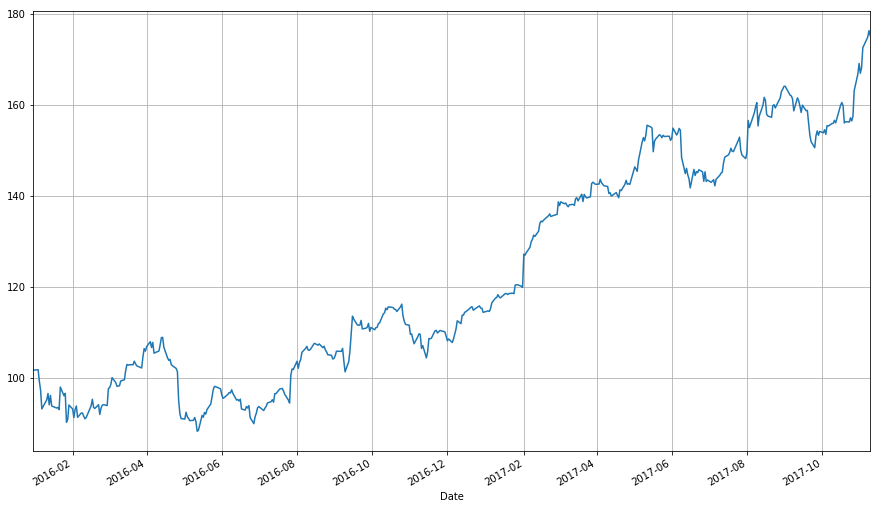

In [9]:
# Plot the adjusted closing price of AAPL
apple["Adj Close"].plot(grid = True)


In [10]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain), while a red candlestick indicates a day where the open was higher than the close (a loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is the open and which the close).

Candlestick charts are popular in finance and some strategies in technical analysis use them to make trading decisions, depending on the shape, color, and position of the candles

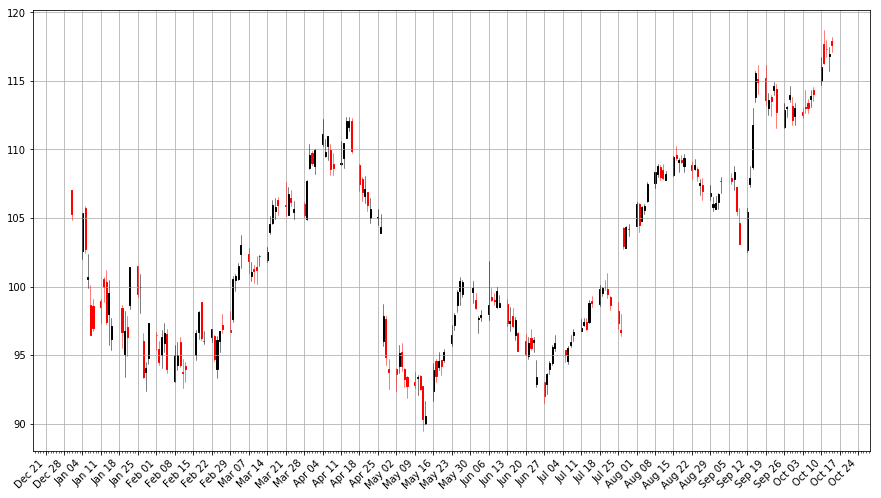

In [13]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

pandas_candlestick_ohlc(apple[:200])

In [16]:
microsoft = data.DataReader("MSFT", "yahoo", start, end)
google = data.DataReader("GOOG", "yahoo", start, end)

In [18]:
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})

stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,101.703697,758.880005,53.084164
2016-01-04,101.790649,741.840027,52.433533
2016-01-05,99.239845,742.580017,52.672737
2016-01-06,97.297760,743.619995,51.715916
2016-01-07,93.191338,726.390015,49.917099


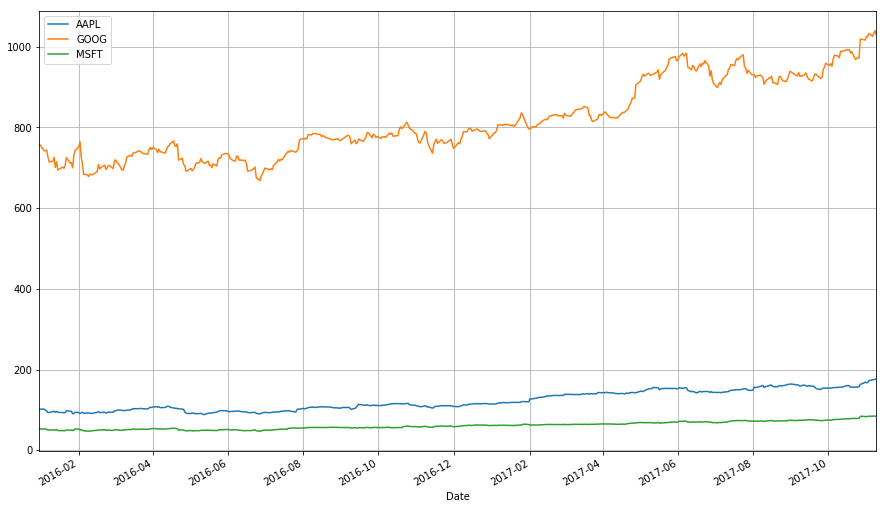

In [19]:
stocks.plot(grid = True)

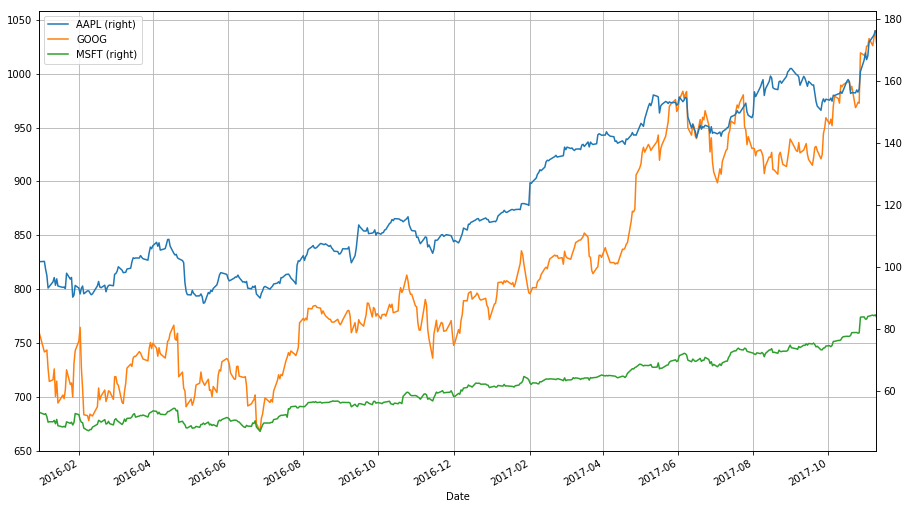

In [20]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

In [21]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,1.000000,1.000000,1.000000
2016-01-04,1.000855,0.977546,0.987743
2016-01-05,0.975774,0.978521,0.992250
2016-01-06,0.956679,0.979891,0.974225
2016-01-07,0.916302,0.957187,0.940339


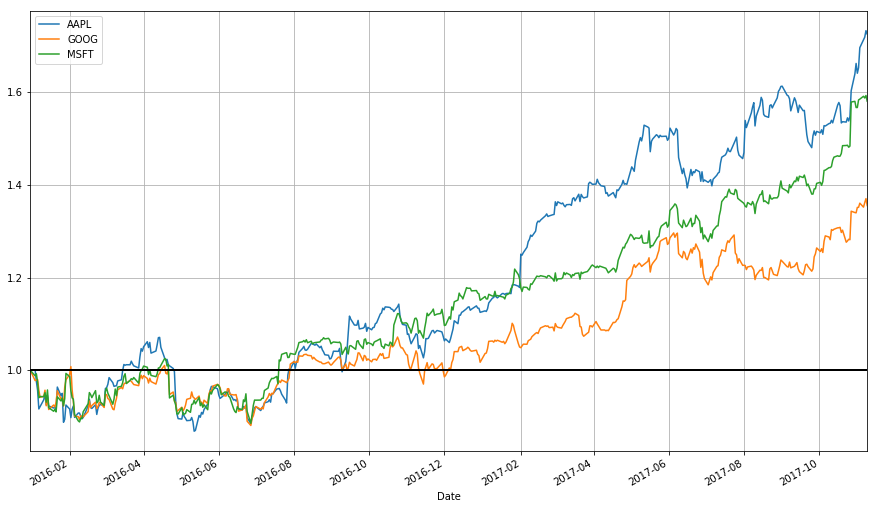

In [22]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [25]:
# Let's use NumPy's log function, though math's log function would work just as well
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2015-12-31,NaN,NaN,NaN
2016-01-04,0.000855,-0.022710,-0.012332
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402


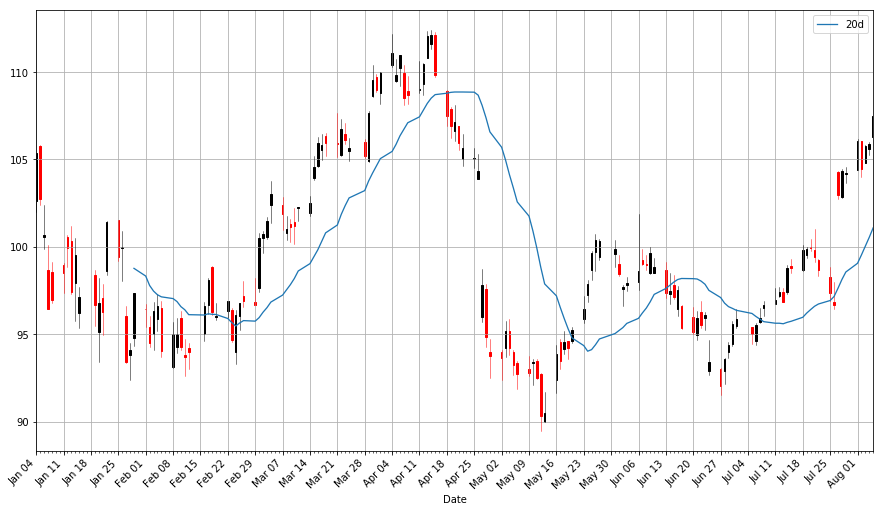

In [26]:
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

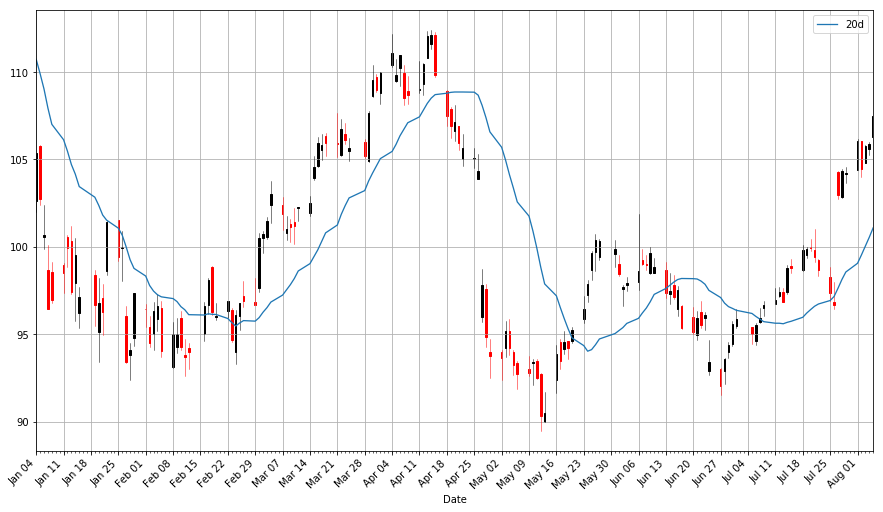

In [28]:
start = datetime.datetime(2010,1,1)
apple = data.DataReader("AAPL", "yahoo", start, end)
apple["20d"] = np.round(apple["Close"].rolling(window = 20, center = False).mean(), 2)

pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

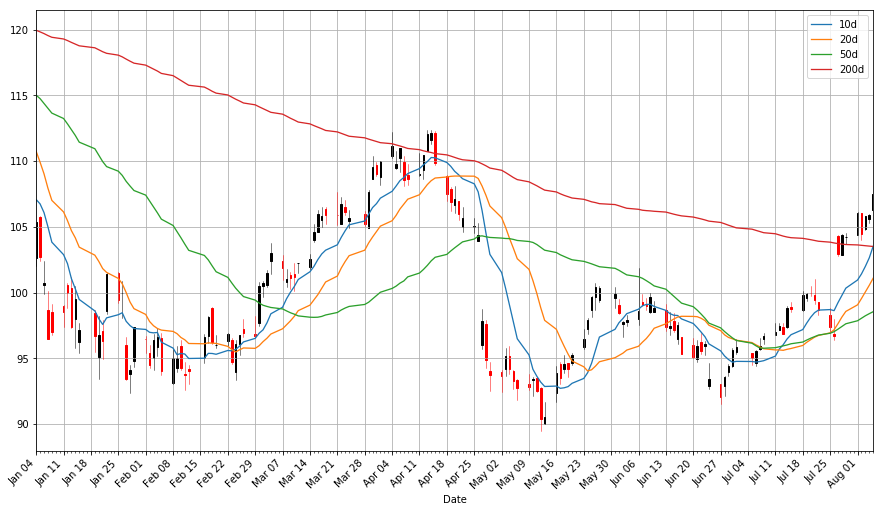

In [31]:
apple["5d"] = np.round(apple["Close"].rolling(window = 5, center = False).mean(), 2)
apple["10d"] = np.round(apple["Close"].rolling(window = 10, center = False).mean(), 2)
apple["50d"] = np.round(apple["Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Close"].rolling(window = 200, center = False).mean(), 2)


pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-08-07',:], otherseries = ["10d","20d", "50d", "200d"])